# Using ANN to predict stock price

From [Stock Data Analysis with Python](https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/):

_In decades, computer science has joined advanced mathematics in revolutionizing finance and trading, the practice of buying and selling of financial assets for the purpose of making a profit. In recent years, trading has become dominated by computers; algorithms are responsible for making rapid split-second trading decisions faster than humans could make (so rapidly, the speed at which light travels is a limitation when designing systems). Additionally, **machine learning and data mining techniques are growing in popularity in the financial sector**, and likely will continue to do so. For example, **high-frequency trading (HFT) is a branch of algorithmic trading where computers make thousands of trades in short periods of time**, engaging in complex strategies such as statistical arbitrage and market making. While algorithms may outperform humans, the technology is still new and playing an increasing role in a famously turbulent, high-stakes arena. HFT was responsible for phenomena such as the 2010 flash crash and a 2013 flash crash prompted by a hacked Associated Press tweet about an attack on the White House._

From [here](https://towardsdatascience.com/neural-networks-to-predict-the-market-c4861b649371):

_Finance is highly nonlinear and sometimes stock price data can even seem completely random. Traditional time series methods such as ARIMA and GARCH models are effective only when the series is stationary, which is a restricting assumption that requires the series to be preprocessed by taking log returns (or other transforms). However, the main issue arises in implementing these models in a live trading system, as there is no guarantee of stationarity as new data is added._

### Time series data

A time series is a sequence of vectors (or scalars) which depend on time $t$.

$ \{~x(t_0), x(t_1),~\dots,~x(t_{i-1}), x(t_i), x(t_{i+1}),~\dots~\} $

which is an output from some process $P$ in which we are interested.

$ \boxed { P } \longrightarrow x(t) $

A time-series is a **collection of observations or measurements taken over a period of time**, generally in equal intervals. Time-series only contain numeric data types and are **indexed by time**. In other words, time-series data is always sortable by time.

Phenomena described by time series can be 


* **discrete** (stock closing value each day, number of sales per day) 


* **continuous** (continuous signal)

    * $t$ is real-valued, and $x(t)$ is a continuous signal
    
    * **continuous** phenomena can be turned into **discrete** via **sampling or resampling**
    
    * in uniform sampling, if the sampling period is chosen as $\delta t$, then
    
    $ \{ x(t) \} = \{ ~ x(0), x(\Delta t), x(2 \Delta t), x(3 \Delta t), ~ \dots ~ \} $
    
In addition to describing either discrete or continuous phenomena, time series can also be **deterministic** vs **stochastic**, governed by **linear** vs **nonlinear** dynamics, _etc._

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import optimizers
import quandl
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Define `plot_time_series`

In [2]:
def plot_time_series(series_to_plot, summary_stats=False,
                     create_plot=True, show_plot=True, ax=None,
                     color='blue', linestyle='-', linewidth=1, alpha=1.,
                     plot_title="", ylabel="", xlabel="Date", tick_label_size=14,
                     x_log=False, y_log=False,
                     highlight_0=True, highlight_0_color='black',
                     minmax=True, mean=True, median=True, units="",
                     highlight=None, caption_lift=1.03):
    """
    a function to plot a line plot of provided time series

    (optional) highlights a period of time with an orange rectangle
    (optional) plots minmax, mean, median of the provided Series
    (optional) x and y axes can (separately) be set to logarithmic scales

    can be used to plot several lines on the same plot
    via several calls to this function
    parameters 'create_plot', 'show_plot', and 'ax' are used to control
    several plots as follows:

    if only one line --'create_plot' = True, 'show_plot' = True
                                        (default)
    if more then one line -- first plot -- create_plot = True, show_plot = False
                       subsequent plots -- create_plot = False, show_plot = False
                                           need to get axis created from the first plot
                                           through ax = plt.gca()
                                           and provide to this function in the second call
                                           as ax = ax
                             final plot    create_plot = False, show_plot = True, ax = ax
    ------------------- plot parameters -----------------------------
    :param series_to_plot: pandas.Series -- Series to be plotted
    :param summary_stats:  boolean       -- whether to show summary stats for the Series
    :param create_plot:    boolean       -- whether to create figure and axis
                                            (set to False for subsequent plots on same axis)
    :param show_plot:      boolean       -- whether to show the plot
                                            (set to False for subsequent plots on same axis)
    :param ax:          matplotlib axis  -- if provided, plot on this axis
                                            (if subsequent plot, provide ax)
    ----------------- main line parameters --------------------------
    :param color:          string        -- color to be used for the main line (matplotlib)
    :param linestyle:      string        -- linestyle to be used for the main line  (matplotlib)
    :param linewidth:      int           -- linewidth to be used for the main line (matplotlib)
    :param alpha:          alpha         -- alpha (transparency) to be used for the main line
    ------------------- axis parameters -----------------------------
    :param plot_title:     string        -- title of the chart
    :param xlabel:         string        -- label for x axis
    :param ylabel:         string        -- label for y axis
    :param tick_label_size:    int       -- size of labels on x and y ticks
    :param y_log:          boolean       -- whether to use log scale for y
    :param x_log:          boolean       -- whether to use log scale for x
    ------------- highlight origin parameters -----------------------
    :param highlight_0:    boolean       -- whether to highlight to origin (y=0)
    :param highlight_0_color:  string    -- color used to highlight the origin
    ----------- min, max, mean, median, units -----------------------
    :param minmax:         boolean       -- whether to plot the min and max values
    :param mean :          boolean       -- whether to plot the mean
    :param median:         boolean       -- whether to plot the median
    :param units:          string        -- units to be added at the end of captions

    :param caption_lift:   float         -- value used to lift captions above lines
    :param highlight:      list          -- list of min x and max x of plot region to highlight
    """
    if summary_stats:
        print(ylabel, "summary statistics")
        print(series_to_plot.describe())

    # set font parameters
    font = dict(family='serif', color='darkred', weight='normal', size=16)

    if create_plot:
        # create figure and axis
        f, ax = plt.subplots(1, figsize=(16, 8))

    # plot the time series
    ax.plot(series_to_plot, color=color, linestyle=linestyle,
            linewidth=linewidth, alpha=alpha)

    if y_log:
        # set y scale to logarithmic
        ax.set_yscale('log')

    if x_log:
        # set x scale to logarithmic
        ax.set_xscale('log')

    if highlight_0:
        # draw a horizontal line at 0
        ax.axhline(0, linestyle='--', linewidth=2, color=highlight_0_color)

    if minmax:
        # highlight min and max
        ser_min = series_to_plot.min()
        ax.axhline(ser_min, linestyle=':', color='red')
        ax.text(series_to_plot.index[len(series_to_plot) // 3], ser_min * caption_lift,
                "Min: {0:.2f}{1}".format(ser_min, units), fontsize=14)
        ser_max = series_to_plot.max()
        ax.axhline(series_to_plot.max(), linestyle=':', color='green')
        ax.text(series_to_plot.index[len(series_to_plot) // 3], ser_max * caption_lift,
                "Max: {0:.2f}{1}".format(ser_max, units), fontsize=14)

    if mean:
        # plot Series mean
        ser_mean = series_to_plot.mean()
        ax.axhline(ser_mean, linestyle='--', color='deeppink')
        ax.text(series_to_plot.index[len(series_to_plot) // 3], ser_mean * caption_lift,
                "Mean: {0:.2f}{1}".format(ser_mean, units), fontsize=14)

    if median:
        # plot Series median
        ser_median = series_to_plot.median()
        ax.axhline(ser_median, linestyle=':', color='blue')
        ax.text(series_to_plot.index[int(len(series_to_plot) * 0.7)], ser_median * caption_lift,
                "Median: {0:.2f}{1}".format(ser_median, units), fontsize=14)

    if highlight:
        ax.axvline(highlight[0], alpha=0.5)
        ax.text(highlight[0], series_to_plot.max() / 2,
                highlight[0], ha='right',
                fontsize=14)
        ax.axvline(highlight[1], alpha=0.5)
        ax.text(highlight[1], series_to_plot.min() / 2,
                highlight[1], ha='left',
                fontsize=14)
        ax.fill_between(highlight, series_to_plot.min() * 1.1,
                        series_to_plot.max() * 1.1, color='orange', alpha=0.2)

    # set axis parameters
    ax.set_title(plot_title, fontdict=font)
    ax.set_xlabel(xlabel, fontdict=font)
    ax.set_ylabel(ylabel, fontdict=font)
    ax.tick_params(labelsize=tick_label_size)

    if show_plot:
        plt.show()
    return

### Define train / test split

In [3]:
def train_test_split(input_data, train_subset_ratio):
    """

    :param input_data:  -- data to be split
    :param train_subset_ratio:  -- ratio to used to generate training subset
    :return: train -- training subset
             test  -- testing subset

    """
    # set train subset ratio
    train_size = int(len(input_data) * train_subset_ratio)

    # split the data set into train and test
    train, test = input_data[0:train_size], input_data[train_size:len(input_data)]
    print('Observations: %d' % (len(input_data)))
    print("\nTrain_test split ratio: {0:.2f}%".format(train_subset_ratio * 100))
    print('\nTraining Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))

    return train, test

### Define `plot_split`

In [4]:
def plot_split(train, test, plot_title="", ylabel="y",
               train_caption_lift=2.5, test_caption_lift=2.5):
    """
    a function to plot the train-test split
    :param train:                     -- train subset
    :param test:                      -- test subset
    :param plot_title:                -- title of the plot
    :param ylabel:                    -- label for y axis
    :param test_caption_lift:         -- lift of test line label on the plot
    :param train_caption_lift:        -- lift of train line label on the plot
    :return:
    """
    # plot train data
    plot_time_series(train, plot_title=plot_title,
                     ylabel=ylabel, y_log=True,
                     alpha=0.4, mean=False, median=False, minmax=False, show_plot=False)

    # get axis generated by the previous call to the plotting function
    ax = plt.gca()

    # plot test data on the same axis
    plot_time_series(test, color='green',
                     plot_title=plot_title, ylabel=ylabel,
                     alpha=0.4, mean=False, median=False, minmax=False,
                     create_plot=False, show_plot=False, ax=ax)

    # plot split line
    ax.axvline(test.index[0], linestyle='--', color='black')

    # add captions
    ax.text(train.index[len(train) // 3], train.mean() * train_caption_lift,
            'Training data', color='blue', fontsize=16)
    ax.text(test.index[len(test) // 3], test.mean() * test_caption_lift,
            'Test data', color='darkgreen', fontsize=16)

    plt.show()
    return

### Define `smape`

$ \large{ SMAPE= \frac{100%} {n} \sum \limits_{t=1}^{n} \frac{|F_t - A_t|} {|A_t| + |F_t|) / 2} } $

In [20]:
def smape(Y_true_value, Y_pred):
    return 100/len(Y_true_value)\
        * np.sum(2 * np.abs(Y_pred - Y_true_value)\
                 / (np.abs(Y_true_value) + np.abs(Y_pred)))

### Get stock data from Quandl

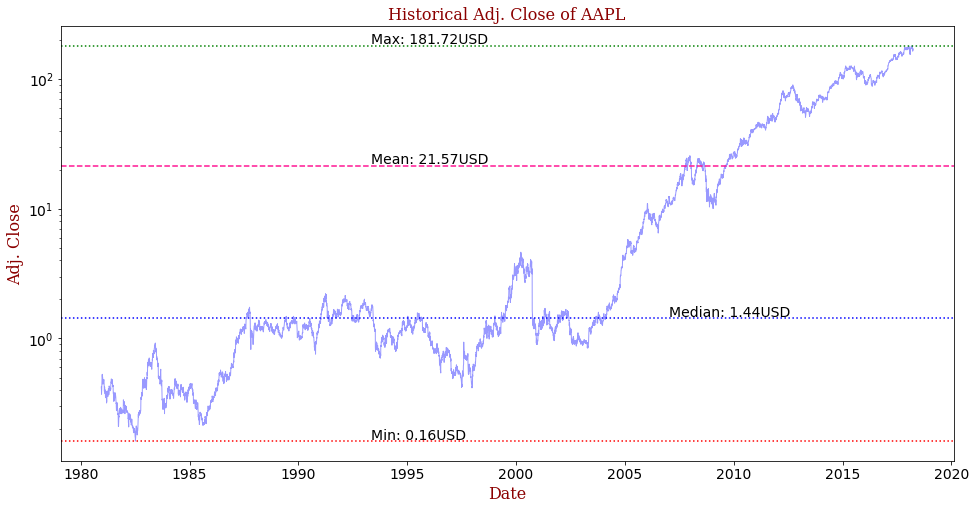

Open   High    Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                          
1980-12-12  28.75  28.87  28.75  28.75  2093900.0          0.0          1.0   
1980-12-15  27.38  27.38  27.25  27.25   785200.0          0.0          1.0   
1980-12-16  25.37  25.37  25.25  25.25   472000.0          0.0          1.0   
1980-12-17  25.87  26.00  25.87  25.87   385900.0          0.0          1.0   
1980-12-18  26.63  26.75  26.63  26.63   327900.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume  
Date                                                                 
1980-12-12   0.422706   0.424470  0.422706    0.422706  117258400.0  
1980-12-15   0.402563   0.402563  0.400652    0.400652   43971200.0  
1980-12-16   0.373010   0.373010  0.371246    0.371246   26432000.0  
1980-12-17   0.380362   0.382273  0.380362    0.380362   21610400.0  
1980-12-18   0.391536   0.393300  0.391536    0.391536   18362400.0

In [5]:
# set time interval (displayed for example, full time interval requested with these parameters)
start = datetime.datetime(1800, 1, 1)
end = datetime.date.today()
 
# Quandl API key from your personal account
api_key = '7__Wy8c2tpqaSnHRyQfp'
    
s = "AAPL"
apple = quandl.get("WIKI/" + s, api_key=api_key)
apple.index = pd.to_datetime(apple.index, format = '%Y-%m-%d')

# plot obtained time series
plot_time_series(apple['Adj. Close'], y_log=True,
                 plot_title='Historical Adj. Close of ' + s, ylabel='Adj. Close', minmax=True,
                 alpha=0.4, units='USD')

# show the top 5 rows of the obtained DataFrame
apple.head()

### Resampling

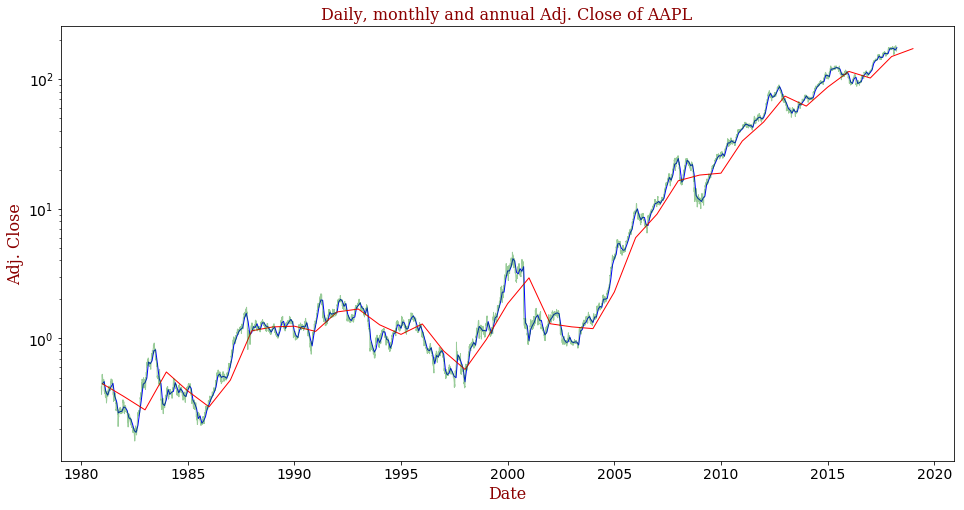

In [6]:
apple_monthly_mean = apple.resample("M").mean()
apple_annual_mean = apple.resample("Y").mean()

title = 'Daily, monthly and annual Adj. Close of AAPL'
col_name = 'Adj. Close'

series_to_plot1 = apple_monthly_mean[col_name]
series_to_plot2 = apple_annual_mean[col_name]
series_to_plot3 = apple[col_name]

plot_time_series(series_to_plot1, summary_stats=False, y_log=True, color='blue',
                 plot_title=title, ylabel=col_name,
                 mean=False, median=False, minmax=False,
                 alpha=1.0, units='USD', show_plot=False)
ax = plt.gca()
plot_time_series(series_to_plot2, summary_stats=False, y_log=True, color='red',
                 plot_title=title, ylabel=col_name,
                 mean=False, median=False, minmax=False,
                 alpha=1.0, units='USD', create_plot=False, show_plot=False, ax=ax)
plot_time_series(series_to_plot3, summary_stats=False, y_log=True, color='green',
                 plot_title=title, ylabel=col_name,
                 mean=False, median=False, minmax=False,
                 alpha=0.4, units='USD', create_plot=False, ax=ax)

### Embedding of time series

Temporal data presents a challenge to deal with because time is constantly moving forward, next obervation often depends on the values of observations prior to it. However, this also offers us a way to _transform_ a **one-dimensional time vector** into **infinite-dinemsional spatial vector**.

We can accomplish such transformation by setting up a shift register of delays, so we can retain successive values of out time series. Then we can treat each past value as an additional spatial dimension in the input space to our predictor.

This **implicit transformation** of a **one-dimensional time vector** into an **infinite-dimensional spatial vector** is called **_embedding_**.

The input space to our **predictor must be finite**. At each instant $t$, we **truncate the history** to **only the previous $d$ samples**, where $\large{d}$ is called the **embedding dimension**.

<img src='img/pic_1.png' width='500'>

In [7]:
train_path = "part-00000-dca064db-f907-4493-9058-c46de55927a8-c000.csv"
test_path = "part-00000-ae5017c8-fabc-4520-8422-5d3e4bf0caea-c000.csv"

In [8]:
train = pd.read_csv(train_path)
train.head()

Close       x-1       x-2       x-3       x-4       x-5       x-6  \
0  0.564732  0.569196  0.540179  0.551339  0.575893  0.602679  0.616071   
1  0.544643  0.564732  0.569196  0.540179  0.551339  0.575893  0.602679   
2  0.546875  0.544643  0.564732  0.569196  0.540179  0.551339  0.575893   
3  0.558036  0.546875  0.544643  0.564732  0.569196  0.540179  0.551339   
4  0.553571  0.558036  0.546875  0.544643  0.564732  0.569196  0.540179   

        x-7       x-8       x-9       ...            x-15      x-16      x-17  \
0  0.609375  0.627232  0.642857       ...        0.475446  0.462054  0.450893   
1  0.616071  0.609375  0.627232       ...        0.504464  0.475446  0.462054   
2  0.602679  0.616071  0.609375       ...        0.529018  0.504464  0.475446   
3  0.575893  0.602679  0.616071       ...        0.551339  0.529018  0.504464   
4  0.551339  0.575893  0.602679       ...        0.580357  0.551339  0.529018   

       x-18      x-19  target_1day  target_1week  target_2weeks  \
0  0.486607  0.513393     0.544643      0.587054       0.575893   
1  0.450893  0.486607     0.546875      0.569196       0.571429   
2  0.462054  0.450893     0.558036      0.580357       0.553571   
3  0.475446  0.462054     0.553571      0.587054       0.533482   
4  0.504464  0.475446     0.587054      0.584821       0.504464   

   target_1month  target_4months  
0       0.486607        0.488839  
1       0.486607        0.495536  
2       0.470982        0.500000  
3       0.466518        0.488839  
4       0.455357        0.488839  

[5 rows x 25 columns]

In [9]:
test = pd.read_csv(test_path)
test.head()

Close        x-1        x-2        x-3        x-4        x-5  \
0  48.642857  49.509998  49.604286  49.921429  49.657143  49.522858   
1  47.614285  48.642857  49.509998  49.604286  49.921429  49.657143   
2  48.020000  47.614285  48.642857  49.509998  49.604286  49.921429   
3  48.552856  48.020000  47.614285  48.642857  49.509998  49.604286   
4  48.647144  48.552856  48.020000  47.614285  48.642857  49.509998   

         x-6        x-7        x-8        x-9       ...             x-15  \
0  49.535713  49.938572  49.742859  49.468571       ...        50.099998   
1  49.522858  49.535713  49.938572  49.742859       ...        50.430000   
2  49.657143  49.522858  49.535713  49.938572       ...        50.060001   
3  49.921429  49.657143  49.522858  49.535713       ...        50.021427   
4  49.604286  49.921429  49.657143  49.522858       ...        49.535713   

        x-16       x-17       x-18       x-19  target_1day  target_1week  \
0  48.915714  48.265713  47.407143  46.779999    47.614285     47.888573   
1  50.099998  48.915714  48.265713  47.407143    48.020000     47.771427   
2  50.430000  50.099998  48.915714  48.265713    48.552856     47.455715   
3  50.060001  50.430000  50.099998  48.915714    48.647144     48.111427   
4  50.021427  50.060001  50.430000  50.099998    47.888573     47.857143   

   target_2weeks  target_1month  target_4months  
0      48.201427      46.657143       54.847141  
1      49.689999      47.491428       54.877144  
2      49.358570      46.678570       53.925713  
3      49.442856      46.451427       54.277142  
4      49.062859      45.751427       54.945713  

[5 rows x 25 columns]

### Possible types of processing time series

Possible types of processing tasks for time series include:

* **predict** future values of $x[t]$

* **classify** a series into one of a few classes:

    * "price will go up"
    
    * "price will go down -- sell now"
    
    * "no change"
    
* **describe** a series using a few parameter values of some model

* **transform** one time series into another

    * oil prices $\mapsto$ interest rates

### Predicting the future

Extending backward from time $t$, we have time series $ \{ ~ x[t], ~ x[t− 1], ~ \dots ~ \} $ . 

From this, we now want to estimate $x$ at some future time

$ \hat{x}[t + s] ~ = ~ f( x[t], ~ x[t-1] ~, ~ \dots ~ ) $

where $\large{s}$ is called the **horizon of prediction**.

If we choose horizon of prediction $s$ to be 1 sample into the future, $\implies s=1$

This is a **function approximation problem**. To solve it, we will adhere to the following **methodology**:


1. **Split** the available historical time series **data into _training_ and _test_ subsets**. 
    * this **can be accomplished by selecting a point in time**
    
    * all the data **prior to the split** point will be used for **_training_** of the model
    
    * all the data **following the split** point will be used to _**test**_ it


2. **Assume a generative model**


3. For every point $x[t_i]$ in the training set, **train the generative model** 
    * a _sliding_ or _expanding gate_ moves through all the data in the **_training_** subset via a loop
    * **each position** of the gate (iteration of the loop) represents a **moment in the past $t_i$** captured in the training subset  
    * values of the time series that **preceeded $t_i$** are used as the **vector of inputs $X$**, 
        * **shape and length of $X$ is determined by the type of the gate** (_expanding_ or _sliding_) **and its length** 
    * **next sample after $t_i$** (in the case of horizon of prediction $s=1$) is **used as the target variable $y$**
    * model is **trained by continuously moving the gate over all of the training data**


4. **Test model performance** by using it to **make predictions over the test set** (the part of the available historical time series data that **has not been used in the training** of the model)
    * using the same mechanic as was used for training, the _gate_ moves through the **_test_** subset and 
    * **vectors of inputs $X$ are fed** into the trained model to **make predictions about the next value of $y$** (next value of time series after the _gate_)
    * model predictions are **compared to the real values** of the time series in the **_test_** subset, prediction **error is calculated**

### Three classes of linear process models encountered in Digital Signal Processing (DSP) theory 

Time series are the **focus of several overlapping disciplines**:

* **Information Theory** deals with describing stochastic time series.

* **Dynamical Systems Theory** deals with describing and manipulating mostly non-linear deterministic time series.

* **Digital Signal Processing (DSP)** deals with describing and manipulating mostly linear time series, both deterministic and stochastic.

**Digital Signal Processing (DSP)** proposes three main classes of linear process models:

* **Autoregressive** ($AR[p]$) models

$AR[p]$ at its heart is an _Infinite Impulse Response (IIR) filter_ (input $u[t]$ contributes to $x[t]$ at time $t$, but otherwise $x[t]$ _is a weighted sum of its own past samples_ given a coefficient vector $\alpha_i$) applied to some (unknown) internal signal, $\epsilon[t]$. $p$ is the order of that filter. 

$$ \large{ x[t] = \sum_{i=1}^p a_i x[t-i] ~ + ~ \epsilon[t] } $$

if on average $\epsilon[t]$ is small compared to $x[t]$, then we can estimate $\hat{x}[t]$ using

$$ \large{ \hat{x} ~ \equiv ~ x[t] ~ - ~ \epsilon [t] = \sum_{i=1}^p w_i x [t-i] } $$ 

The $w_i$'s are estimates of $\alpha_i$'s.

A diagram of an _Infinite Impulse Response (IRR) filter_:

<img src='img/pic_3.png' width='300'>

* **Moving Average** ($MA[q]$) models

$MA[q]$ at its heart is a _Finite Impulse Response (FIR) filter_ (convolution of the input signal $u[t]$ with a given coefficient vector $ \{ \beta_i \})$ applied to some (unknown) internal signal, $\epsilon[t]$. $q + 1$ is the order of that filter.

$$ \large{ x[t] ~ = ~ \sum_{i=0}^q \beta_i \epsilon [t-i] } $$

In this case, we cannot assume that $\epsilon [t]$ is negligible; $x[t]$ would have to be negligible. This method is seldom used alone in practice, as by using the equation above, we are not making explicit use of the past values of $x[t]$.

A diagram of an _Finite Impulse Response (FIR) Filter_:

<img src='img/pic_4.png' width='300'>

* **Autoregressive Moving Average** ($ARMA[p, q]$) models

A combination of the $AR[p]$ and $MA[q]$ models:

$$ \large{ x[t] ~ = ~ \sum_{i=1}^p \alpha_i x [t-i] ~ + ~ \sum_{i=1}^q \beta_i \epsilon [t-i] + \epsilon[t] } $$

To estimate values of $x[t]$, we assume that $\epsilon[t]$ at time $t$ is small relative to $x[t]$. We can obtain estimates of past values of $\epsilon[t]$ at time $t-i$ from past true values of $x[t]$ and past values of $\hat{x}[t]$:

$$ \large{ \hat{\epsilon}[t-i] ~ = ~ x[t-i] ~ - ~ \hat{x}[t-i] } $$

The estimate for $x[t]$ is then 

$$ \large{ \hat{x}[t] = \sum_{i=1}^p \alpha_i x [t-i] ~ + ~ \sum_{i=1}^q \beta_i \hat{\epsilon} [t-i] } $$

### Linear DSP models as Linear Artificial Neural Networks (Linear ANNs)

| DSP Filter | DSP Model | NN Connections |
|------------|-----------|----------------|
|     FIR    |    MA[q]  |  feedforward   |
|     IIR    |    AR[p]  |    recurrent   |

<img src='img/pic_5.png' width='700'>

and so can be trained via backpropagation using the equation

$$ \large{ x[t] ~ = ~ \sum_{i=0}^q \beta_i \epsilon [t-i] } $$

### ANN as a non-linear $ARMA[p, q]$ model

Once ANNs have been introduced, we can replace $\sum$'s with a non-linear activation function. Non-linear models are more powerful, but need more training data, and are also subject to a range of problems, such as:

* overfitting

* local minima

* excessive computational requirements

* _etc._

A diagram of a non-linear $ARMA[p,q]$ model implemented via an ANN:

<img src='img/pic_6.png'>

## Train / test data split

### Train / test split using backtesting

Based on [https://machinelearningmastery.com](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/):

_When evaluating a model for time series forecasting, **we are interested in the performance of the model on data that was not used to train it**. In machine learning, we call this unseen or out of sample data. In applied machine learning, **we often split our data into a train and a test set**: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that._

_The fast and powerful methods in machine learning, such as using **train-test splits and k-fold cross validation** (repeats the process by systematically splitting the data into k groups, each given a chance to be a held out model), **do not work in the case of time series** data because they **ignore the temporal components** inherent in the problem._

_This is because they **assume that there is no relationship between the observations**, that each observation is independent. This is **not true of time series data**, where the time dimension of observations means that we cannot randomly split them into groups. Instead, **we must split data up and respect the temporal order** in which values were observed._

_In time series forecasting, this **evaluation of models on historical data** is called [**backtesting**](https://www.investopedia.com/terms/b/backtesting.asp). In some time series domains, such as meteorology, this is called **hindcasting**, as opposed to forecasting. Backtesting allows a trader to simulate a trading strategy using historical data to generate results and analyze risk and profitability before risking any actual capital. Good correlation between backtesting, out-of-sample and forward performance testing results (paper trading, following system's logic in a live market) is vital for determining the viability of a trading system._

### Trading strategy, backtesting, and model overfitting

From [Investopedia](https://www.investopedia.com/terms/b/backtesting.asp):

_The **ideal backtest chooses sample data from a relevant time period** of a duration **that reflects a variety of market conditions**. In this way, one can better judge whether the results of the backtest represent a fluke or sound trading. For backtesting to provide meaningful results, **traders must develop their strategies and test them in good faith, avoiding bias as much as possible**. That means the **strategy should be developed without relying on the data used in backtesting**. That’s harder than it seems. Traders generally build strategies based on historical data. They must be strict about testing with different data sets from those they train their models on. Otherwise, the backtest will produce glowing results that mean nothing._

_Similarly, **traders must also avoid data dredging**, in which they **test a wide range of hypothetical strategies against the same set of data** with will also produce successes that fail in real-time markets, because **there are many invalid strategies that would beat the market over a specific time period by chance**._

_One way to compensate for the tendency to data dredge or cherry pick is to use a strategy that succeeds in the relevant, or in-sample, time period and backtest it with data from a different, or out-of-sample, time period. If in-sample and out-of-sample backtests yield similar results, then they are likely generally valid._

### Backtesting methods

Backtesting can be performed in several ways:

* **Train-Test split** that **respects temporal order of observations**
* **Multiple Train-Test splits** that respect temporal order of observations
* **Walk-Forward Validation** where a model may be updated each time step new data is received

#### Temporal Train-Test split

Using a **train-test split method** to evaluate machine learning models is **fast, data preparation is simple and intuitive**, and **only one model is created and evaluated**. The split can be **performed by selecting an arbitrary split point in the ordered list** of observations and creating two new datasets. Split ratio is determined depending on the amount of data available and the amount of data required, splits of 50-50, 70-30, 90-10, or similar can be performed.

Observations: 9400

Train_test split ratio: 80.00%

Training Observations: 7520
Testing Observations: 1880


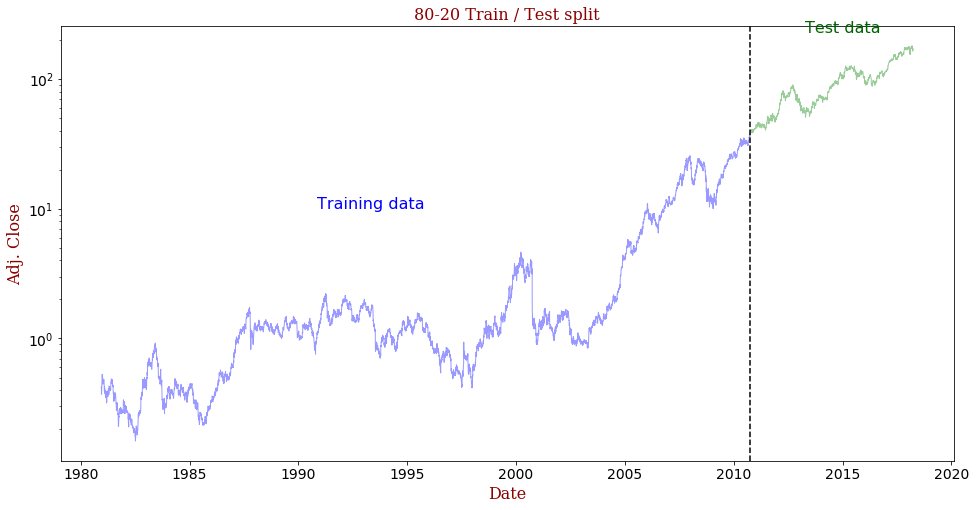

In [10]:
# select the series to be modeled
col_name = 'Adj. Close'
X = apple[col_name]


# set train subset ratio
train_subset_ratio = 8 / 10
split_title = '80-20 Train / Test split'

train_temp, test_temp = train_test_split(X, train_subset_ratio)

plot_split(train_temp, test_temp, plot_title=split_title, ylabel=col_name)

#### Multiple Train-Test Splits

From [https://machinelearningmastery.com](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

_The process of splitting the time series into train and test sets can be repeated multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data._

_This can be done manually by repeating the process described in the previous section with different split points, or alternately, `scikit-learn` library provides this capability for us in the `TimeSeriesSplit` object. You must specify the number of splits to create and the `TimeSeriesSplit` to return the indexes of the train and test observations for each requested split._

The total number of training and test observations are calculated each split iteration (i) as follows:

$ \text{Training size} = \large{ \frac{i \cdot N_{samples}} {N_{splits} + 1} } $, where $i$ is the number of split iteration

$ \text{Test size} = \large{ \frac{N_{samples}} {N_{splits} + 1} } $

_Test size stays consistent on each split iteration. This means that performance statistics calculated on the predictions of each trained model will be consistent and can be combined and compared. What differs is the number of records used to train the model each split, offering a larger and larger history to work with. This may make an interesting aspect of the analysis of results._

_Alternately, this too could be controlled by holding the number of observations used to train the model consistent and only using the same number of the most recent (last) observations in the training dataset each split to train the model, 33 in this contrived example._

_A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available._

#### Walk Forward Validation

From [https://machinelearningmastery.com](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

_In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption._

_There are few decisions to make:_

1. _Minimum Number of Observations. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point)._
2. _Sliding or Expanding Window. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used._

_After a sensible configuration is chosen for your test-setup, models can be trained and evaluated._

* _Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model._
* _The model makes a prediction for the next time step._
* _The prediction is stored or evaluated against the known value._
* _The window is expanded to include the known value and the process is repeated (go to step 1.)_

_Because this methodology involves moving along the time series one-time step at a time, it is often called Walk Forward Testing or Walk Forward Validation. Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast._

_This capability is currently not available in `scikit-learn`, although you could contrive the same effect with a carefully configured `TimeSeriesSplit`._

_Below is an example of how to split data into train and test sets using the Walk Forward Validation method. Within the loop is where you would train and evaluate your model. This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. This improved estimate comes at the computational cost of creating so many models._

_As such, careful attention needs to be paid to the window width and window type. These could be adjusted to contrive a test to harness on your problem that is significantly less computationally expensive. Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross validation of the time series world and is recommended for your own projects._

## Modeling using Artificial Neural Networks (ANN)

Two neural network models are attempted: 

* [Multilayer Perceptron (MLP)](https://medium.com/engineer-quant/multilayer-perceptron-4453615c4337)

* [Long Short Term Model (LSTM)](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)

_**Multilayer Perceptron (MLP)**_

_**MLPs** are **simplest form of neural networks**, where an input is fed into the model, and using certain weights, the values are fed forward through the hidden layers to produce the output. The **learning comes from backpropagating through the hidden layers to change the value of the weights between each neuron**. An issue with MLPs is the lack of ‘memory’. There is no sense of what happened in previous training data and how that might and should affect the new training data. In the context of our model, the difference between the ten days of data in one dataset and another dataset might be of importance (for example) but MLPs do not have the ability to analyse these relationships._

_**Long Short Term Model (LSTM)**_

_**LSTMs**, or in general **Recurrent Neural Networks (RNNs)** have the **ability of storing certain information about the data for later use** and this **extends the network’s capability in analyzing the complex structure of the relationships** between stock price data. A **problem with RNNs is the vanishing gradient problem**. This is due to the fact that when the number of layers increases, the learning rate (value less that one) is multiplied several times, and that causes the gradient to keep decreasing. This is **combated by LSTMs**, making them more effective._

### Normalizing data

From [here](https://towardsdatascience.com/neural-networks-to-predict-the-market-c4861b649371):

_An **important step in using the stock price data is to normalize the data**. This would **usually mean that you minus the average and divide by standard deviation** but in our case, we want to be able to use this system on live trade over a period of time. So **taking the statistical moments might not be the most accurate way to normalize the data**. So I have merely divided the entire data by 200 (an arbitrary number that makes everything small). Although it seems as though the normalization was plucked out of thin air, it is still effective in making sure the weights in the neural network do not grow too large._

### Optimizing using ADAM

_`Adam` optimizer is gaining popularity in the machine learning community because it is a more efficient algorithm to optimize compared to traditional stochastic gradient descent. The advantages are best understood by looking at the advantages of two other extensions of stochastic gradient descent:_

_Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).
Adam can be thought of as combining the benefits of the above extensions and that is why I have chosen to use Adam as my optimizer._

## Matrix of inputs `X` and vector of targets `y`

Generated by selecting appropriate columns from the training and test subsets generated above.

In [11]:
## Vectors of inputs
### Training subset
X_train = train.loc[:, 'Close':'x-19']
### Test subset
X_test = test.loc[:, 'Close':'x-19']
X_test.head()

Close        x-1        x-2        x-3        x-4        x-5  \
0  48.642857  49.509998  49.604286  49.921429  49.657143  49.522858   
1  47.614285  48.642857  49.509998  49.604286  49.921429  49.657143   
2  48.020000  47.614285  48.642857  49.509998  49.604286  49.921429   
3  48.552856  48.020000  47.614285  48.642857  49.509998  49.604286   
4  48.647144  48.552856  48.020000  47.614285  48.642857  49.509998   

         x-6        x-7        x-8        x-9       x-10       x-11  \
0  49.535713  49.938572  49.742859  49.468571  50.018570  49.535713   
1  49.522858  49.535713  49.938572  49.742859  49.468571  50.018570   
2  49.657143  49.522858  49.535713  49.938572  49.742859  49.468571   
3  49.921429  49.657143  49.522858  49.535713  49.938572  49.742859   
4  49.604286  49.921429  49.657143  49.522858  49.535713  49.938572   

        x-12       x-13       x-14       x-15       x-16       x-17  \
0  50.021427  50.060001  50.430000  50.099998  48.915714  48.265713   
1  49.535713  50.021427  50.060001  50.430000  50.099998  48.915714   
2  50.018570  49.535713  50.021427  50.060001  50.430000  50.099998   
3  49.468571  50.018570  49.535713  50.021427  50.060001  50.430000   
4  49.742859  49.468571  50.018570  49.535713  50.021427  50.060001   

        x-18       x-19  
0  47.407143  46.779999  
1  48.265713  47.407143  
2  48.915714  48.265713  
3  50.099998  48.915714  
4  50.430000  50.099998

In [12]:
## Targets
### Training subset
y_train = train.loc[:, 'target_1day':'target_4months']
### Test subset
y_test = test.loc[:, 'target_1day':'target_4months']
y_test.head()

target_1day  target_1week  target_2weeks  target_1month  target_4months
0    47.614285     47.888573      48.201427      46.657143       54.847141
1    48.020000     47.771427      49.689999      47.491428       54.877144
2    48.552856     47.455715      49.358570      46.678570       53.925713
3    48.647144     48.111427      49.442856      46.451427       54.277142
4    47.888573     47.857143      49.062859      45.751427       54.945713

### Correlations between targets with different horizon of prediction

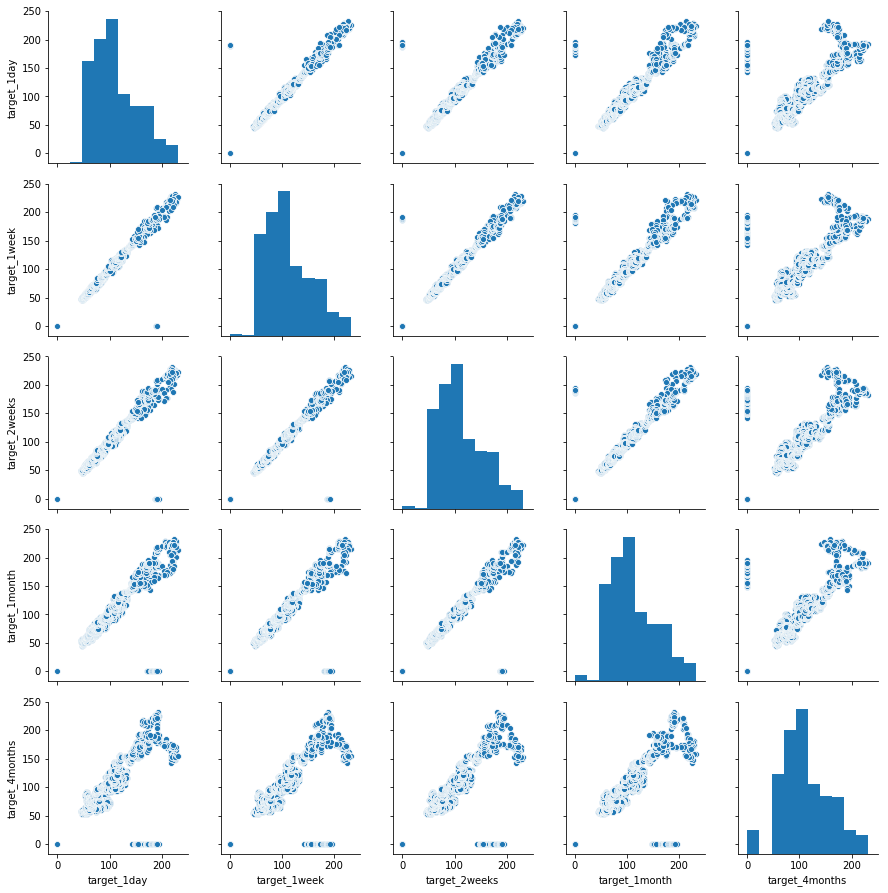

In [13]:
sns.pairplot(y_test); plt.show()

#### Crop rows with missing values from test subset based on target horizon

In [62]:
y_test.tail()

target_1day  target_1week  target_2weeks  target_1month  target_4months
1978   188.470001           0.0            0.0            0.0             0.0
1979   188.720001           0.0            0.0            0.0             0.0
1980   189.949997           0.0            0.0            0.0             0.0
1981   191.240005           0.0            0.0            0.0             0.0
1982     0.000000           0.0            0.0            0.0             0.0

In [63]:
drop_last_rows = 1
y_test_cropped = y_test.drop(y_test.tail(drop_last_rows).index)
y_test_cropped.tail()

target_1day  target_1week  target_2weeks  target_1month  target_4months
1977   186.789993    191.240005            0.0            0.0             0.0
1978   188.470001      0.000000            0.0            0.0             0.0
1979   188.720001      0.000000            0.0            0.0             0.0
1980   189.949997      0.000000            0.0            0.0             0.0
1981   191.240005      0.000000            0.0            0.0             0.0

In [64]:
X_test_cropped = X_test.drop(X_test.tail(drop_last_rows).index)
X_test_cropped.tail()

Close         x-1         x-2         x-3         x-4         x-5  \
1977  188.740005  191.050003  195.089996  188.160004  186.529999  188.020004   
1978  186.789993  188.740005  191.050003  195.089996  188.160004  186.529999   
1979  188.470001  186.789993  188.740005  191.050003  195.089996  188.160004   
1980  188.720001  188.470001  186.789993  188.740005  191.050003  195.089996   
1981  189.949997  188.720001  188.470001  186.789993  188.740005  191.050003   

             x-6         x-7         x-8         x-9        x-10        x-11  \
1977  186.119995  183.729996  181.710007  180.910004  178.899994  172.910004   
1978  188.020004  186.119995  183.729996  181.710007  180.910004  178.899994   
1979  186.529999  188.020004  186.119995  183.729996  181.710007  180.910004   
1980  188.160004  186.529999  188.020004  186.119995  183.729996  181.710007   
1981  195.089996  188.160004  186.529999  188.020004  186.119995  183.729996   

            x-12        x-13        x-14        x-15        x-16        x-17  \
1977  172.500000  174.520004  175.529999  175.850006  174.970001  173.149994   
1978  172.910004  172.500000  174.520004  175.529999  175.850006  174.970001   
1979  178.899994  172.910004  172.500000  174.520004  175.529999  175.850006   
1980  180.910004  178.899994  172.910004  172.500000  174.520004  175.529999   
1981  181.710007  180.910004  178.899994  172.910004  172.500000  174.520004   

            x-18        x-19  
1977  174.869995  174.330002  
1978  173.149994  174.869995  
1979  174.970001  173.149994  
1980  175.850006  174.970001  
1981  175.529999  175.850006

### Multi-Layer Perceptron (MLP)

In `Keras`, implementing simpler MLP is done by making a sequential model and adding dense layers on top of it:

In [53]:
num_nodes = 8
window_length = 20
learning_rate = 0.0007

model = Sequential()

model.add(Dense(num_nodes, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                input_dim=window_length))
model.add(Dense(num_nodes // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                input_dim=window_length))
#model.add(Dense(num_nodes // 4, activation='relu', kernel_regularizer=regularizers.l2(0.01),
#                input_dim=window_length))
model.add(Dense(1))

adam_opt = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False,
                           clipnorm=1)

model.compile(adam_opt, loss='mse', metrics=['accuracy'])


Model RMSE on the train set: 0.37342396340663314

Model RMSE on the test set: 5.550050404428675

Model SMAPE on the train set: 3.5269133634662033

Model SMAPE on the test set: 2.394531969427865


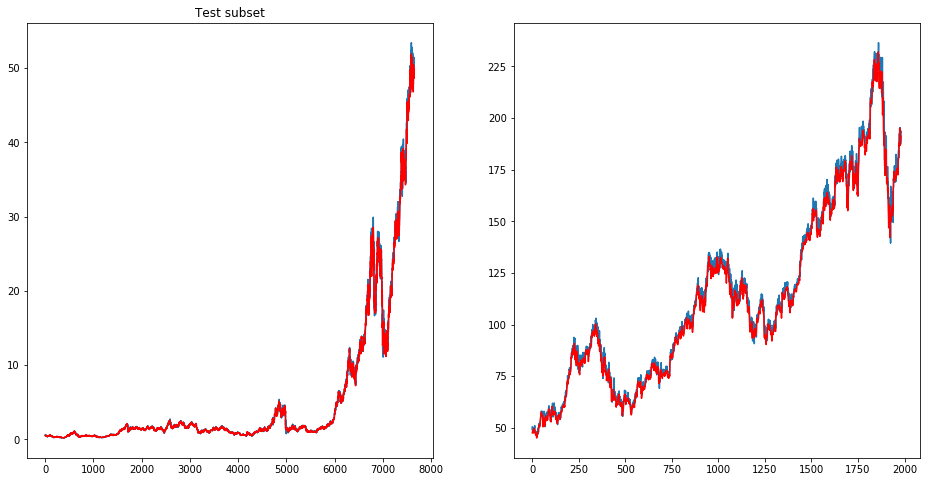

In [66]:
%%time
target_col = 'target_1day'

model.fit(np.array(X_train),
                  np.array(y_train[target_col]),
                  epochs=10, verbose=True)

y_prediction_train = model.predict(np.array(X_train))
y_prediction_train_se = pd.Series(y_prediction_train.T[0])
y_prediction_test = model.predict(np.array(X_test))
y_prediction_test_se = pd.Series(y_prediction_test.T[0])

rmse_train = np.sqrt(mean_squared_error(y_train[target_col], y_prediction_train_se))
rmse_test = np.sqrt(mean_squared_error(y_test[target_col], y_prediction_test_se))
smape_train = smape(y_train[target_col], y_prediction_train_se)
smape_test = smape(y_test[target_col], y_prediction_test_se)
print("\nModel RMSE on the train set:", rmse_train)
print("\nModel RMSE on the test set:", rmse_test)    
print("\nModel SMAPE on the train set:", smape_train)
print("\nModel SMAPE on the test set:", smape_test)

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

y_prediction_train_se.plot(ax=axes[0])
y_train[target_col].plot(ax=axes[0], color='red')
axes[0].set_title("Training subset")

y_prediction_test_se.plot(ax=axes[1])
y_test_cropped[target_col].plot(ax=axes[1], color='red')
axes[0].set_title("Test subset")

plt.show()